# <font color=red>RNN for both summarization and classification</font>
- One training --> two tasks


- Preprocessing+EDA --> Hyper paras
- Tokenizer+Generate samples
- Define Add_loss Layer
- Define Model for both tasks
- Model training
- Extract part of trained model to make inference and prediction in both tasks
- Evaluation on summarization - BLEU score
- Evaluation on classification - Accuracy

In [1]:
# !pip install tensorflow_gpu==1.15.0 
# !pip install nltk


# import os
# from google.colab import drive
# drive.mount('/content/drive')


# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior() 

# import sys
# pypath = "/content/drive/My Drive/Colab Notebooks/CS584-HW5/"# Colab path
# sys.path.append(pypath)


## Import

In [2]:
from collections import Counter, defaultdict
from gensim.models import word2vec
# from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from nltk import bigrams, trigrams , ngrams
from nltk.corpus import reuters, stopwords
from nltk import bleu
from sklearn import preprocessing
# from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim.downloader as api
import glob
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nltk, string
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string, os 
import tensorflow as tf
import warnings
# InteractiveShell.ast_node_interactivity = "all"
# warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from myutils_V4 import eda_MAX_NB_WORDS,eda_MAX_DOC_LEN, text_preprocessor, cnn_model, history_plot
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # 关掉warning信息
import os

from tensorflow.keras.layers import Input, Dense, Lambda, Add, Layer,\
Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Multiply
# !conda install graphviz -y
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot


os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"


## Gloabl parameters

In [3]:
epochs = 100
patience = 20


num_samples = 30000

latent_dim = 128
embedding_dim = 200
iteration_per_epoch = 600
# batch_size=32

rmsprop = optimizers.RMSprop(lr=0.0001, rho=0.9)

## Read & Parsing

In [4]:

########### Word level
char_level_switch = False
symbols = ['xxxstart', 'xxxend' ]


# ############ Char level
# char_level_switch = True
# symbols = ['\t', '\n']
# max_output_length = 60

# num_samples = 100
set_random = 25468

MAX_NB_WORDS_ratio_text = 0.95
MAX_DOC_LEN_ratio_text = 0.92
# MAX_NB_WORDS_ratio_selected_text = 0.90
# MAX_DOC_LEN_ratio_selected_text = 0.90

test_ratio = 0.1
val_ratio = 0.05 # when fitting, we can set validation_split

Machine = 'mymac'
# Machine = 'mydesk'
# Machine = 'mywin'
# Machine = 'colab'



def get_machine_path(Machine='mydesk'):
    if Machine == 'mymac':
        path =  "/Users/wy/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"
    elif Machine == 'mydesk':    
        path =  "E:/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"
    elif Machine == 'mywin':    
        path =  "D:/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"
    elif Machine == 'colab':  
        path = "/content/drive/My Drive/Colab Notebooks/CS584-Proj-improving/dataset"# Colab path
    else:
        print("I need to update my path")
        return None
    return path

wd = get_machine_path(Machine)+'dataset/data/'
filename = ['train.csv','test.csv']
dt = pd.read_csv(wd+filename[0], nrows=num_samples).astype(str)

### Save the result
saving_path = "./RNN_Combined/"
file_name = saving_path+'R_M2_' + Machine
if not os.path.exists(saving_path):
    os.mkdir(saving_path)

In [5]:
def normalize_string_keep_dot(s):
    s = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)  # deleted website
    s = re.sub(r'([!.?])', r' \1', s) # separate those symbols as one word
    s = re.sub(r'[^a-zA-Z.!?\d]+', r' ', s) # keep words, !?. and number
    s = re.sub(r'\s+', r' ', s) # drop other special symbol /t 
    return s

def tokenize_string(s):# For computing bleu
    s = re.sub(r'[^a-zA-Z]+', r' ', s) 
    return s.lower()

dt['normalized_text'] = [normalize_string_keep_dot(i) for i in dt["text"]]
dt['normalized_selected_text'] = [normalize_string_keep_dot(i) for i in dt["selected_text"]]
data = dt.copy()

replace_map = {'sentiment': {'neutral': 1, 'positive': 0, 'negative': 2}}
data.replace(replace_map, inplace=True)
train, test = train_test_split(data, test_size=test_ratio, shuffle=True, random_state=set_random)


## Split dataset
- The dataset has been shuffle before

In [6]:
dt = data.iloc[0:int(len(data)*(1-test_ratio)),:]

## TRAIN AND VAL
x_train, x_val = train_test_split(dt, test_size=val_ratio, random_state=123)
train_data = x_train.reset_index(drop=True)
val_data = x_val.reset_index(drop=True)

## TEST
test_data =  data.iloc[-int(len(data)*test_ratio)::,:].reset_index(drop=True)

print("len of training data: ", len(train_data)) 
print("len of val data: ", len(val_data))
print("len of testing data: ", len(test_data))

len of training data:  23500
len of val data:  1237
len of testing data:  2748


In [7]:
target_col = 'sentiment'
y_train = to_categorical(train_data[target_col])
y_test = to_categorical(test_data[target_col])

## Build input ( the class write in the myutlis.py)
- EDA 
- Tokenizer (leave into the <font color=red>text_preprocessor </font> class)
- max_fr_words = MAX_NB_WORDS+1 for padding 0
- Initialize W2V with gensim CBow 

### text - words level

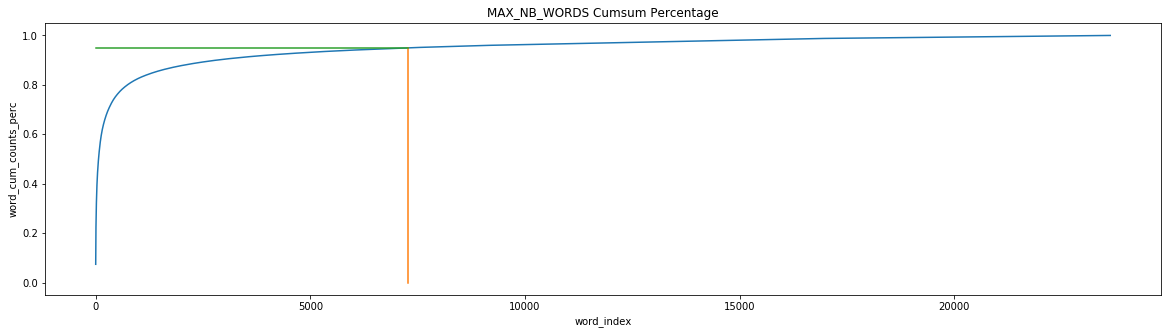

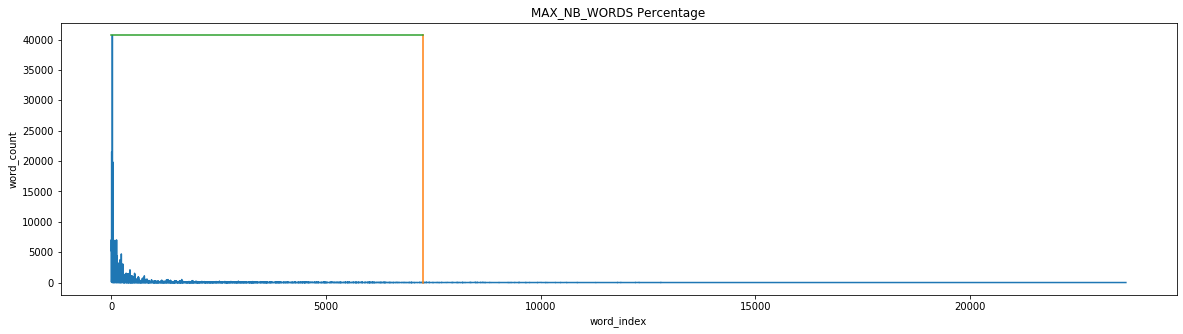

Cut index with 95.0 % of corpus:  7271 

    index  word  count
0      24     .  40672
1       8     i  21531
2      35     !  19822
3      12    to  13203
4      18   the  11702
5      43     a   8923
6       1   you   7051
7     122    my   7014
8      85    it   6937
9      70   and   6352
10      5     ?   5520
11      0    is   5236
12     32    in   4954
13     86     s   4866
14    233   for   4706
15    138     t   4411
16     22    of   4050
17     25  that   3853
18    205    me   3755
19     42    on   3736


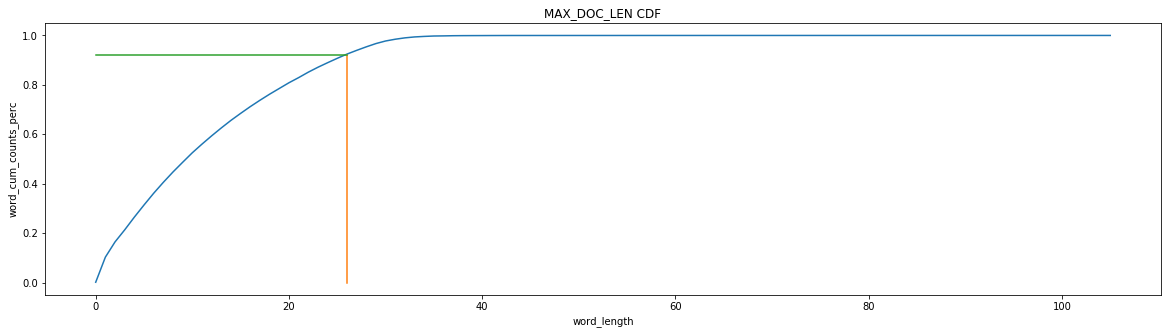

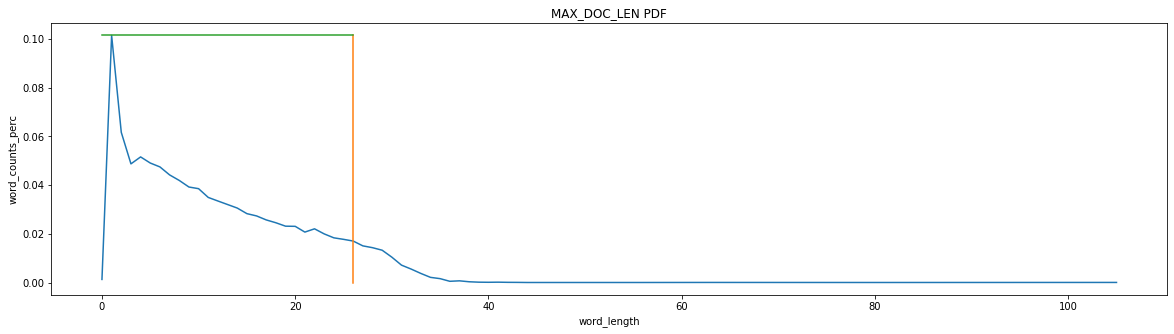

Cut index with 92.0 % of corpus:  26
CPU times: user 3.36 s, sys: 533 ms, total: 3.89 s
Wall time: 3.9 s


In [8]:
%%time
corpus = train_data['normalized_text'].append(train_data['normalized_selected_text'])
MAX_NB_WORDS = eda_MAX_NB_WORDS(corpus, ratio = MAX_NB_WORDS_ratio_text, filters='',char_level = char_level_switch)
MAX_DOC_LEN = eda_MAX_DOC_LEN(corpus, ratio = MAX_DOC_LEN_ratio_text, filters='',char_level = char_level_switch)

# initialize
processor_x = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, corpus,filters ='',char_level = char_level_switch) 
data_en = processor_x.generate_seq(train_data['normalized_text'])
data_fr = processor_x.generate_seq(train_data['normalized_selected_text'])

data_en_test = processor_x.generate_seq(test_data['normalized_text'])
data_fr_test = processor_x.generate_seq(test_data['normalized_selected_text'])

vocab_size = MAX_NB_WORDS+1
max_en_len = MAX_DOC_LEN

data_fr_categorical = to_categorical(data_en, num_classes = vocab_size)
data_fr_categorical_test = to_categorical(data_en_test, num_classes = vocab_size)



# LSTM for both sentiment classification and summarization

## ADD_LOSS layer

In [9]:
class CELayer(Layer): 
    def __init__(self, **kwargs): 
        super(CELayer, self).__init__(**kwargs) 

    def call(self, x, mask=None): # inputs都是batch 的layer 
        output = x[0] #(?,27, vocab_size)
        target = x[1]  #(?,27, vocab_size)
        input_2 = x[2] # just for visulization
        ce_batch = K.sum( K.categorical_crossentropy(target, output)) # (?,27) --> (?)
        self.add_loss(ce_batch, x) # 这里重新计算loss, 并且增加到loss上. add_loss
        return output, input_2


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 200)      1454400     Input[0][0]                      
                                                                 loss_adj[0][1]                   
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 26, 256), (N 336896      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 26, 7272)     1868904     bidirectional[0][0]          

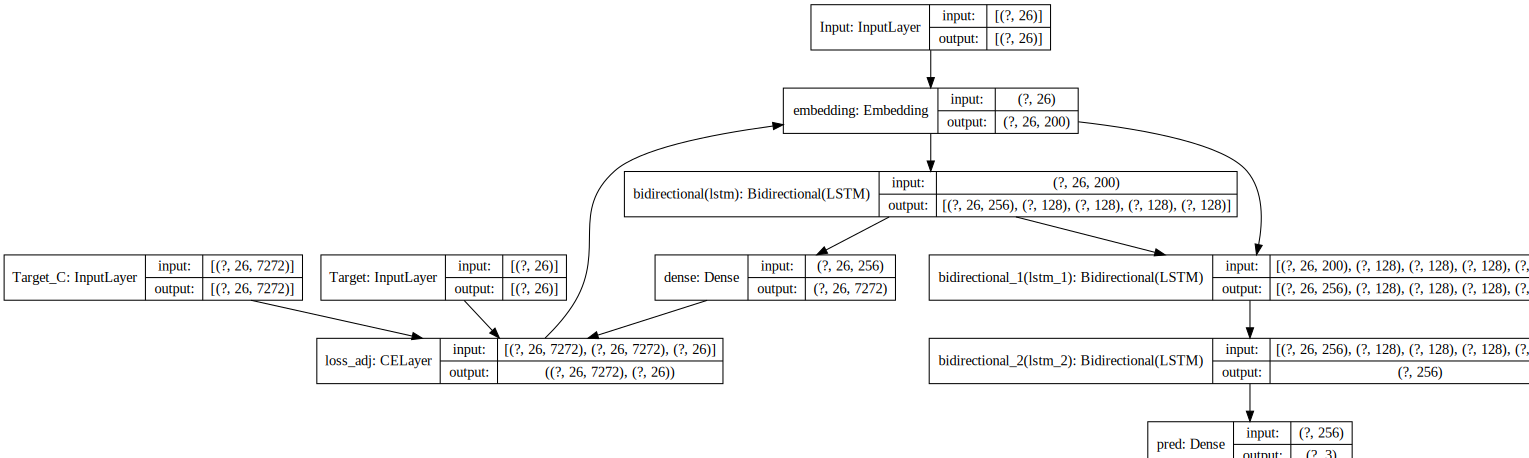

In [10]:
### 初始化所有layer
input_1_words = Input(shape= (max_en_len, ), dtype=tf.int64, name='Input') # 统一time stamp 长度
input_2_words = Input(shape= (max_en_len, ), dtype=tf.int64, name='Target')
input_2_words_categorical = Input(shape=(max_en_len, vocab_size), dtype=tf.float32, name='Target_C')

embedding = Embedding(vocab_size, embedding_dim, weights=None, trainable=True) # 
lstm_1 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.0, recurrent_dropout=0.5)) 
lstm_2 = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.0, recurrent_dropout=0.5))
dense2word = Dense(vocab_size, activation='softmax') # (? , timestamp, vocab_size) 
lstm_3 = Bidirectional(LSTM(latent_dim, return_sequences=False, return_state=False, dropout=0.0, recurrent_dropout=0.5)) 
sentiment_pred = Dense(3, activation='softmax', name='pred')

# _, forward_h, forward_c, backward_h, backward_c



embed_1 = embedding(input_1_words)
lstm_out_1, forward_h_1, forward_c_1, backward_h_1, backward_c_1 = lstm_1(embed_1, initial_state=None) #
output_1 = dense2word(lstm_out_1) # for drag the parameters to selected text generate.
####### loss for summarization 
output_1, input_2_words_V = CELayer(name='loss_adj')([output_1, input_2_words_categorical, input_2_words]) # 后面没用到output_1, 所以model
embed_2 = embedding(input_2_words_V) # (?, timestamp, embedding_dim)
lstm_out_2, forward_h_2, forward_c_2, backward_h_2, backward_c_2 = lstm_2(embed_2, initial_state=[forward_h_1, forward_c_1, backward_h_1, backward_c_1]) # 因为不是decoder        
# combined_context = Add(name='add_up')([lstm_out_1, lstm_out_2]) #  Add?
lstm_out_3 = lstm_3(lstm_out_2, initial_state=[forward_h_2, forward_c_2, backward_h_2, backward_c_2]) # how to choose initial state?
pred = sentiment_pred(lstm_out_3)




model = Model([input_1_words, input_2_words, input_2_words_categorical], pred)
model.summary()
SVG(model_to_dot(model,show_shapes=True, dpi=70,show_layer_names=True).create(prog='dot', format='svg'))

In [11]:
%%time
BestModel_Name = file_name + 'naive_combined'
model.compile(optimizer= rmsprop, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

#### Best model selection 
BEST_MODEL_FILEPATH = BestModel_Name
earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')

batch_size = int( len(data_en) / iteration_per_epoch )+1 # 200 iteration as one epoch

history = model.fit([data_en, data_fr, data_fr_categorical], y_train, verbose = 2, epochs = epochs, batch_size=batch_size, validation_split=val_ratio, callbacks=[earlyStopping, checkpoint])
model.load_weights(BestModel_Name)


Train on 22325 samples, validate on 1175 samples
Epoch 1/100
22325/22325 - 188s - loss: 4806.4886 - categorical_accuracy: 0.5660 - val_loss: 3529.1536 - val_categorical_accuracy: 0.5515
Epoch 2/100
22325/22325 - 183s - loss: 3388.9648 - categorical_accuracy: 0.6080 - val_loss: 3169.4025 - val_categorical_accuracy: 0.6323
Epoch 3/100
22325/22325 - 175s - loss: 3014.2726 - categorical_accuracy: 0.6256 - val_loss: 2784.4676 - val_categorical_accuracy: 0.6426
Epoch 4/100
22325/22325 - 164s - loss: 2619.7296 - categorical_accuracy: 0.6354 - val_loss: 2375.8249 - val_categorical_accuracy: 0.6604
Epoch 5/100
22325/22325 - 163s - loss: 2199.4907 - categorical_accuracy: 0.6357 - val_loss: 1978.1692 - val_categorical_accuracy: 0.6545
Epoch 6/100
22325/22325 - 177s - loss: 1853.6735 - categorical_accuracy: 0.6447 - val_loss: 1687.5383 - val_categorical_accuracy: 0.6460
Epoch 7/100
22325/22325 - 174s - loss: 1595.8222 - categorical_accuracy: 0.6567 - val_loss: 1465.3425 - val_categorical_accuracy:

loss val_loss


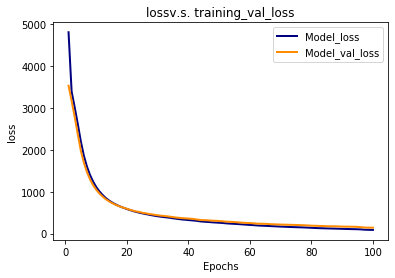

categorical_accuracy val_categorical_accuracy


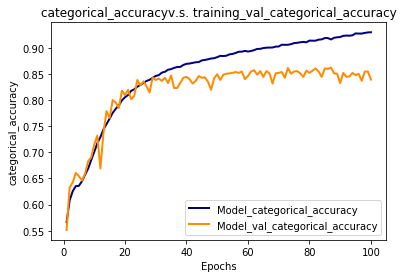

/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.91      0.80      0.85       853
           1       0.87      0.92      0.89      1113
           2       0.81      0.84      0.82       782

   micro avg       0.86      0.86      0.86      2748
   macro avg       0.86      0.85      0.86      2748
weighted avg       0.87      0.86      0.86      2748
 samples avg       0.86      0.86      0.86      2748

2748/2748 - 5s - loss: 61.5987 - categorical_accuracy: 0.8614
categorical_accuracy: 86.14%






In [12]:
history_plot(history)
y_pred = model.predict([data_en_test, data_fr_test, data_fr_categorical_test])
print(classification_report(y_test, y_pred>0.5))
scores = model.evaluate([data_en_test, data_fr_test, data_fr_categorical_test], y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

# Retrieve part of parameters

## part-1 Summarization

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 26)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 26, 200)           1454400   
_________________________________________________________________
bidirectional (Bidirectional [(None, 26, 256), (None,  336896    
_________________________________________________________________
dense (Dense)                (None, 26, 7272)          1868904   
Total params: 3,660,200
Trainable params: 3,660,200
Non-trainable params: 0
_________________________________________________________________


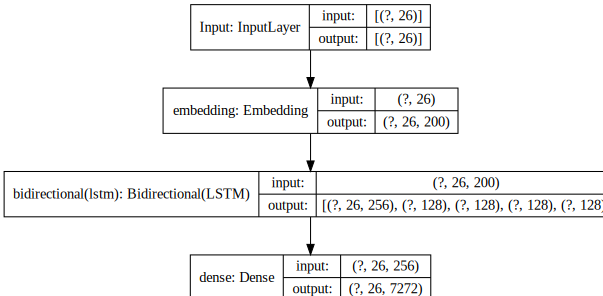

In [13]:
input_1_words = Input(shape= (max_en_len, ), dtype=tf.int64, name='Input') # 统一time stamp 长度

embed_1 = embedding(input_1_words)
lstm_out_1, forward_h_1, forward_c_1, backward_h_1, backward_c_1= lstm_1(embed_1, initial_state=None) #
output_1 = dense2word(lstm_out_1) # for drag the parameters to selected text generate.
# output_1_V = Lambda(lambda x:K.argmax(x[0], axis=-1))(output_1) # 这句话会把batch弄没掉 # 但是会有什么影响?
Model_summ = Model(input_1_words, output_1)
Model_summ.compile(optimizer= rmsprop, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


Model_summ.summary()
SVG(model_to_dot(Model_summ,show_shapes=True, dpi=70,show_layer_names=True).create(prog='dot', format='svg'))

In [14]:
# history_plot(history)
y_pred = Model_summ.predict(data_en_test)
y_pred_index = np.argmax(y_pred, axis=-1)

In [15]:
reverse_map = {1:'neutral', 0: 'positive', 2:'negative'}

In [16]:
for _ in range(10):
    idx = np.random.choice(y_pred_index.shape[0])
    print("="*30)
    print("original text: ", test_data.loc[idx, 'text'])
    print("selected text: ", test_data.loc[idx, 'selected_text']) 
    y_summ_pred_index = np.argmax(Model_summ.predict(data_en_test[idx].reshape(1,-1)), axis=-1)[0]
    print("model summarization: ", " ".join([processor_x.index_word[i] for i in y_summ_pred_index if i !=0]))
    print("")

original text:  what am l doing?? .....nothing much atm
selected text:  what am l doing?? .....nothing much atm
model summarization:  what am l doing ? ? . . . . .nothing much atm

original text:  Trying Resco MobileForms Toolkit and sample. Trial messages ruin everything, the sample has bugs, it's running slow. Poor 1st impression.
selected text:  ruin
model summarization:  trying and . trial messages ruin everything the has bugs it s running slow . poor 1st impression .

original text:  wished didnt spend money last night
selected text:  didnt spend
model summarization:  wished didnt spend money last night

original text:   hay naku!!madaya ka talaga ah hehe ..hey happy mothers day to your mom nga pala   and to your mom also
selected text:  ..hey happy mothers day to your mom
model summarization:  hay ! ah hehe . happy mothers day to your mom and to your mom also

original text:  Rats the Creative VADO's are out of stock at walmart.com I'm too late.
selected text:  too late.
model su

# The reference is the orginal text
- so the BLEU score is high in this case
- The summarization text is the subset of orginal text

In [17]:
def summarizate_result(test_data, attention=False):
    ref_list, summarization = [], [] 
    ### Select a set of sentences from the testing data and print the summarization results from the model (compare to the ground truth).
    for idx in range(len(test_data)):
        # print('-'*30)
        y_summ_pred_index = np.argmax(Model_summ.predict(data_en_test[idx].reshape(1,-1)), axis=-1)[0]
        decoded_sentence = " ".join([processor_x.index_word[i] for i in y_summ_pred_index if i !=0])
        # print('True sentence:', test_data.selected_text[idx])
        
        ref_list.append(test_data.normalized_selected_text[idx]) # tokens
        summarization.append(decoded_sentence)
        
    ref_list = [tokenize_string(sentence).split() for sentence in ref_list]
    hyp_list = [tokenize_string(sentence).split() for sentence in summarization]
    return ref_list, hyp_list, summarization

ref_test, hyp_test, summarization = summarizate_result(test_data, attention=False)

In [18]:
bs = np.array([bleu(ref_test, i) for i in hyp_test])
bs1 = np.mean(bs)
print('S2S BLEU_1: ', bs1)

/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower 

S2S BLEU_1:  0.44689888232258423


## part-2 Classification Only based on input_1_words

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 26)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 26, 200)      1454400     Input[0][0]                      
                                                                 lambda[0][0]                     
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 26, 256), (N 336896      embedding[3][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 26, 7272)     1868904     bidirectional[2][0]        

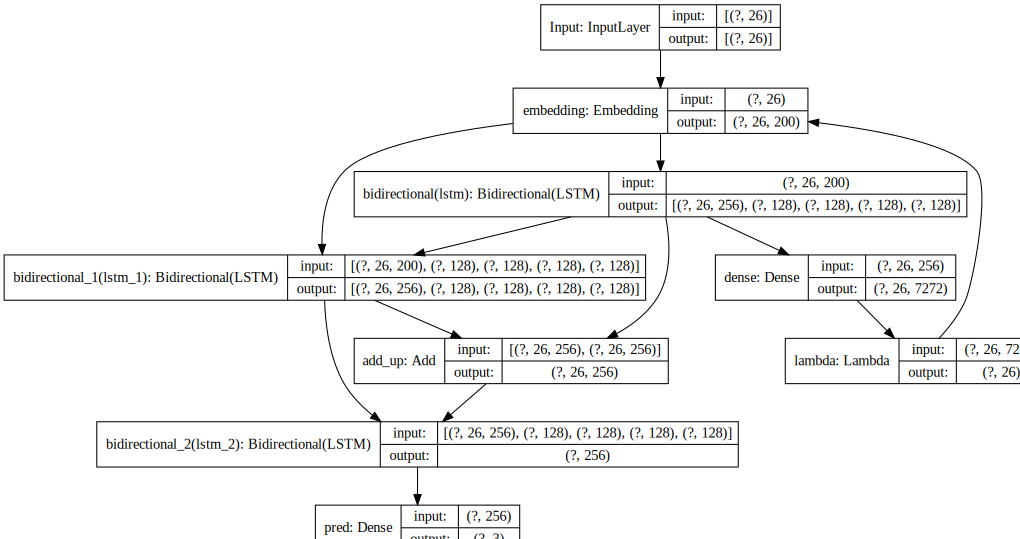

In [19]:
input_1_words = Input(shape= (max_en_len, ), dtype=tf.int64, name='Input') # 统一time stamp 长度


embed_1 = embedding(input_1_words)
lstm_out_1, forward_h_1, forward_c_1, backward_h_1, backward_c_1 = lstm_1(embed_1, initial_state=None) #
output_1 = dense2word(lstm_out_1) # for drag the parameters to selected text generate.

####### loss for summarization 
# output_1, input_2_words_V = CELayer(name='loss_adj')([output_1, input_2_words_categorical, input_2_words]) # 后面没用到output_1, 所以model
# embed_2 = embedding(input_2_words_V) # (?, timestamp, embedding_dim)

output_1_V_C = Lambda(K.argmax, arguments={'axis':-1})(output_1)
# output_1_V = Lambda(lambda x:K.argmax(x[0], axis=1))(output_1)
# output_1_V = tf.expand_dims(output_1_V, axis=0, name=None)
 
embed_2 = embedding(output_1_V_C) # (?, timestamp, embedding_dim)
lstm_out_2, forward_h_2, forward_c_2, backward_h_2, backward_c_2 = lstm_2(embed_2, initial_state=[ forward_h_1, forward_c_1, backward_h_1, backward_c_1]) # 因为不是decoder        
combined_context = Add(name='add_up')([lstm_out_1, lstm_out_2]) #  Add?
lstm_out_3 = lstm_3(combined_context, initial_state=[forward_h_2, forward_c_2, backward_h_2, backward_c_2]) # how to choose initial state?
pred = sentiment_pred(lstm_out_3)


Model_clf = Model(input_1_words, pred)
Model_clf.compile(optimizer= rmsprop, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


Model_clf.summary()
SVG(model_to_dot(Model_clf,show_shapes=True, dpi=70,show_layer_names=True).create(prog='dot', format='svg'))

In [20]:
# Model_clf = Model(input_1_words, pred)

In [21]:
# history_plot(history)
y_pred = Model_clf.predict(data_en_test)
print(classification_report(y_test, y_pred>0.5))
scores = Model_clf.evaluate(data_en_test, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
print( "\n\n\n")

/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/wy/anaconda3/envs/py810/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       853
           1       0.41      0.98      0.57      1113
           2       0.24      0.02      0.03       782

   micro avg       0.40      0.40      0.40      2748
   macro avg       0.22      0.33      0.20      2748
weighted avg       0.23      0.40      0.24      2748
 samples avg       0.40      0.40      0.40      2748

2748/2748 - 4s - loss: 2.5027 - categorical_accuracy: 0.4036
categorical_accuracy: 40.36%






# Final performance

In [22]:
for _ in range(10):
    idx = np.random.choice(y_pred_index.shape[0])
    print("="*30)

    print("sentiment:", reverse_map[test_data.loc[idx, 'sentiment']])
    print("original text: ", test_data.loc[idx, 'text'])
    print("selected text: ", test_data.loc[idx, 'selected_text']) 
    
    y_summ_pred_index = np.argmax(Model_summ.predict(data_en_test[idx].reshape(1,-1)), axis=-1)[0]
    y_clf_pred_index = np.argmax(Model_clf.predict(data_en_test[idx].reshape(1,-1)))
    
    print("model summarization: ", " ".join([processor_x.index_word[i] for i in y_summ_pred_index if i !=0]))
    print("model classification: ", reverse_map[y_clf_pred_index])
    print("")
    

sentiment: negative
original text:   Hello, yourself. Enjoy London. Watch out for the Hackneys. They're mental.
selected text:  They're mental.
model summarization:  hello yourself . enjoy london . watch out for the . they re .
model classification:  neutral

sentiment: neutral
original text:  _truong sunbae* my bad jst scratch wht i said  im talking nonsense here.. lol!!! enjoy the perfs
selected text:  my bad jst scratch wht i said  im talking nonsense here.. lol!!! enjoy the perfs
model summarization:  my bad jst scratch wht i said im talking here . . lol ! ! ! enjoy the
model classification:  neutral

sentiment: positive
original text:   ooohhh imma need you to get on that asap love you
selected text:  love you
model summarization:  imma need you to get on that asap love you
model classification:  neutral

sentiment: positive
original text:   see u bye see u!  i love the hot30
selected text:  i love
model summarization:  see u bye see u ! i love the
model classification:  negative


# Find classification error checking

In [23]:
for _ in range(100):
    idx = np.random.choice(y_pred_index.shape[0])
    if test_data.loc[idx, 'sentiment'] != np.argmax(Model_clf.predict(data_en_test[idx].reshape(1,-1))):
        print("="*30)

        print("sentiment:", reverse_map[test_data.loc[idx, 'sentiment']])
        print("original text: ", test_data.loc[idx, 'text'])
        print("selected text: ", test_data.loc[idx, 'selected_text']) 

        y_summ_pred_index = np.argmax(Model_summ.predict(data_en_test[idx].reshape(1,-1)), axis=-1)[0]
        y_clf_pred_index = np.argmax(Model_clf.predict(data_en_test[idx].reshape(1,-1)))

        print("model summarization: ", " ".join([processor_x.index_word[i] for i in y_summ_pred_index if i !=0]))
        print("model classification: ", reverse_map[y_clf_pred_index])
        print("")


sentiment: positive
original text:  it always rains right after i get my car washed
selected text:  right
model summarization:  it always rains right after i get my car washed
model classification:  neutral

sentiment: positive
original text:  Relaxing with my daughter watching Friends
selected text:  Relaxing
model summarization:  relaxing with my daughter watching friends
model classification:  neutral

sentiment: negative
original text:  please ignore cheesey music
selected text:  ignore
model summarization:  please ignore music
model classification:  neutral

sentiment: positive
original text:   All the best with the Cup Final today. Have fun
selected text:  All the best with the Cup Final today. Have fun
model summarization:  all the best with the cup final today . have fun
model classification:  neutral

sentiment: positive
original text:   Now you only have 2 hours to sleep...  - Rest if you need it.
selected text:  - Rest if you need it.
model summarization:  now you only have 